In [1]:
import math
import asyncio
import submitit
from pathlib import Path
import gc
from collections import defaultdict
from nilearn.connectome import sym_matrix_to_vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import pearsonr
from sklearn.model_selection import (
    train_test_split,
)
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
from tqdm.auto import tqdm

In [ ]:
import jupytext
# Load the current notebook
nb = jupytext.read('path/to/your/notebook.ipynb')

# Set the formats to 'ipynb' and 'py'
nb.metadata['jupytext'] = {'formats': 'ipynb,py'}

# Save the notebook with the updated metadata that includes jupytext configuration
jupytext.write(nb, 'path/to/your/notebook.ipynb')


In [7]:
torch.cuda.empty_cache()
multi_gpu = False

In [3]:
# data_path = Path('~/research/data/victoria_mat_age/data_mat_age_demian').expanduser()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
participants = pd.read_csv("participants.csv")

/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/gpfs3/well/margulies/users/cpy397/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and w

<Axes: xlabel='age', ylabel='Density'>

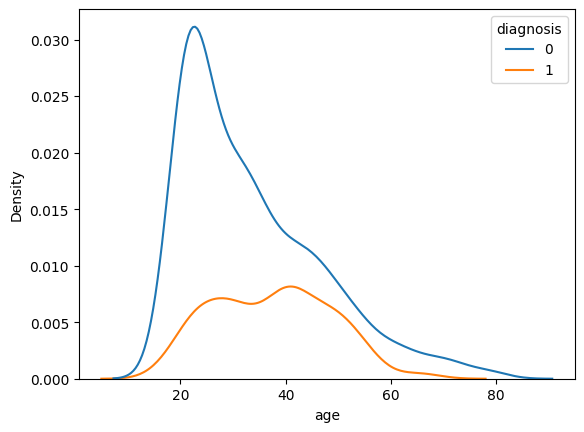

In [6]:
sns.kdeplot(data=participants, x="age", hue="diagnosis")

In [8]:
class MLP(nn.Module):
    def __init__(
        self,
        input_dim_feat,
        input_dim_target,
        hidden_dim_feat,
        output_dim,
        dropout_rate,
    ):
        super(MLP, self).__init__()

        # Xavier initialization for feature MLP
        self.feat_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_feat),
            nn.Linear(input_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim),
        )
        self.init_weights(self.feat_mlp)

        # Xavier initialization for target MLP
        self.target_mlp = nn.Sequential(
            nn.BatchNorm1d(input_dim_target),
            nn.Linear(input_dim_target, hidden_dim_feat),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim_feat, output_dim)
        )
        self.init_weights(self.target_mlp)

        self.decode_target = nn.Sequential(
            nn.Linear(output_dim, hidden_dim_feat),
            nn.BatchNorm1d(hidden_dim_feat),
            nn.ReLU(),
            nn.Linear(hidden_dim_feat, input_dim_target)
        )
        self.init_weights(self.decode_target)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.0)

    def transform_feat(self, x):
        features = self.feat_mlp(x)
        features = nn.functional.normalize(features, p=2, dim=1)
        return features
    
    def transform_targets(self, y):
        targets = self.target_mlp(y)
        targets = nn.functional.normalize(targets, p=2, dim=1)
        return targets
 
    def decode_targets(self, embedding):
        return self.decode_target(y_embedding)

    def forward(self, x, y):
       x_embedding = self.transform_feat(x)
       y_embedding = self.transform_targets(y)
       return x_embedding, y_embedding

In [9]:
class MatData(Dataset):
    def __init__(self, path_feat, path_target, target_name, indices, transform = None, transform_params = None, threshold = 0, random_state=42):
        """
        Initializes the dataset with the capability to handle training and testing splits, 
        including multiple views for augmented data.
        
        Args:
            path_feat (str): Path to the features file.
            path_target (str): Path to the target file.
            transform (callable): A transformation function to apply for augmentation.
            train (bool): Whether the dataset is used for training. False will load the test set.
            test_size (float): Proportion of the dataset to include in the test split.
            random_state (int): Random state for reproducible train-test splits.
        """
        # Load the entire dataset
        features = np.load(path_feat)[indices]
        participant_data = pd.read_csv(path_target)
        targets = participant_data[target_name].values[indices]
        targets = np.expand_dims(targets, axis = 1)

        self.n_sub = len(features)
        self.n_views = 1
        self.transform = transform
        self.targets = targets
        self.transform_params = transform_params if transform_params is not None else {}
        
        vectorized_feat = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in features])
        
        if threshold > 0:
            thrs = np.quantile(np.abs(vectorized_feat), q=threshold, axis=1, keepdims=True)
            vectorized_feat = vectorized_feat * (np.abs(vectorized_feat) >= thrs)
        
        self.n_features = vectorized_feat.shape[-1]
        
        if transform is not None:
            # apply augmentation only in training mode!
            if transform != "copy":
                augmented_features = np.array([self.transform(sample, **self.transform_params) for sample in features])
                augmented_features = np.array([sym_matrix_to_vec(mat, discard_diagonal=True) for mat in augmented_features])
                self.n_views = self.n_views + augmented_features.shape[1]
                self.features = np.zeros((self.n_sub, self.n_views, self.n_features))
                for sub in range(self.n_sub):
                    self.features[sub, 0, :] = vectorized_feat[sub]
                    self.features[sub, 1:, :] = augmented_features[sub]
            else:
                self.features = np.repeat(np.expand_dims(vectorized_feat, axis = 1), 2, axis=1)
        else:
            self.features = np.expand_dims(vectorized_feat, axis = 1)
            
    def __len__(self):
        return self.n_sub

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]
        features = torch.from_numpy(features).float()
        targets = torch.tensor(targets, dtype=torch.float32)
        
        return features, targets

In [10]:
def random_threshold_augmentation(features, threshold):
    # Calculate the 95th percentile threshold
    threshold = np.quantile(features, threshold)
    
    # Apply thresholding: Set values below the threshold to zero
    features_thresholded = np.where(np.abs(features) > threshold, 0, features)
    
    # Generate random values between 0 and the threshold wherever there are zeros
    random_values = np.random.uniform(0, threshold, features.shape)
    augmented_features = np.where(features_thresholded == 0, random_values, features_thresholded)

    # Apply L2 normalization
    norm = np.linalg.norm(augmented_features)
    normalized_features = augmented_features / norm if norm != 0 else augmented_features
    
    
    return np.expand_dims(normalized_features, axis = 0)

In [11]:
# loss from: https://github.com/EIDOSLAB/contrastive-brain-age-prediction/blob/master/src/losses.py
# modified to accept input shape [bsz, n_feats]. In the age paper: [bsz, n_views, n_feats].
class KernelizedSupCon(nn.Module):
    """Supervised contrastive loss: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR
    Based on: https://github.com/HobbitLong/SupContrast"""

    def __init__(
        self,
        method: str,
        temperature: float = 0.07,
        contrast_mode: str = "all",
        base_temperature: float = 0.07,
        krnl_sigma: float = 1.0,
        kernel: callable = None,
        delta_reduction: str = "sum",
    ):
        super().__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature
        self.method = method
        self.kernel = kernel
        self.krnl_sigma = krnl_sigma
        self.delta_reduction = delta_reduction

        if kernel is not None and method == "supcon":
            raise ValueError("Kernel must be none if method=supcon")

        if kernel is None and method != "supcon":
            raise ValueError("Kernel must not be none if method != supcon")

        if delta_reduction not in ["mean", "sum"]:
            raise ValueError(f"Invalid reduction {delta_reduction}")

    def __repr__(self):
        return (
            f"{self.__class__.__name__} "
            f"(t={self.temperature}, "
            f"method={self.method}, "
            f"kernel={self.kernel is not None}, "
            f"delta_reduction={self.delta_reduction})"
        )

    def forward(self, features, labels=None):
        """Compute loss for model. If `labels` is None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, n_features].
                input has to be rearranged to [bsz, n_views, n_features] and labels [bsz],
            labels: ground truth of shape [bsz].
        Returns:
            A loss scalar.
        """
        device = features.device

        if len(features.shape) != 3:
            raise ValueError(
                "`features` needs to be [bsz, n_views, n_feats],"
                "3 dimensions are required"
            )

        batch_size = features.shape[0]
        n_views = features.shape[1]

        if labels is None:
            mask = torch.eye(batch_size, device=device)

        else:
            labels = labels.view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError("Num of labels does not match num of features")

            if self.kernel is None:
                mask = torch.eq(labels, labels.T)
            else:
                mask = self.kernel(labels, krnl_sigma=self.krnl_sigma)

        view_count = features.shape[1]
        features = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == "one":
            features = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == "all":
            features = features
            anchor_count = view_count
        else:
            raise ValueError("Unknown mode: {}".format(self.contrast_mode))

        # Tile mask
        mask = mask.repeat(anchor_count, view_count)

        # Inverse of torch-eye to remove self-contrast (diagonal)
        inv_diagonal = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * n_views, device=device).view(-1, 1),
            0,
        )

        # compute similarity
        anchor_dot_contrast = torch.div(
            torch.matmul(features, features.T), self.temperature
        )

        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        alignment = logits

        # base case is:
        # - supcon if kernel = none
        # - y-aware is kernel != none
        uniformity = torch.exp(logits) * inv_diagonal

        if self.method == "threshold":
            repeated = mask.unsqueeze(-1).repeat(
                1, 1, mask.shape[0]
            )  # repeat kernel mask

            delta = (mask[:, None].T - repeated.T).transpose(
                1, 2
            )  # compute the difference w_k - w_j for every k,j
            delta = (delta > 0.0).float()

            # for each z_i, repel only samples j s.t. K(z_i, z_j) < K(z_i, z_k)
            uniformity = uniformity.unsqueeze(-1).repeat(1, 1, mask.shape[0])

            if self.delta_reduction == "mean":
                uniformity = (uniformity * delta).mean(-1)
            else:
                uniformity = (uniformity * delta).sum(-1)

        elif self.method == "expw":
            # exp weight e^(s_j(1-w_j))
            uniformity = torch.exp(logits * (1 - mask)) * inv_diagonal

        uniformity = torch.log(uniformity.sum(1, keepdim=True))

        # positive mask contains the anchor-positive pairs
        # excluding <self,self> on the diagonal
        positive_mask = mask * inv_diagonal

        log_prob = (
            alignment - uniformity
        )  # log(alignment/uniformity) = log(alignment) - log(uniformity)
        log_prob = (positive_mask * log_prob).sum(1) / positive_mask.sum(
            1
        )  # compute mean of log-likelihood over positive

        # loss
        loss = -(self.temperature / self.base_temperature) * log_prob
        return loss.mean()

In [12]:
def gaussian_kernel(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2 * (krnl_sigma**2))) / (math.sqrt(2 * torch.pi))


def gaussian_kernel_original(x, krnl_sigma):
    x = x - x.T
    return torch.exp(-(x**2) / (2 * (krnl_sigma**2))) / (
        math.sqrt(2 * torch.pi) * krnl_sigma
    )


def cauchy(x, krnl_sigma):
    x = x - x.T
    return 1.0 / (krnl_sigma * (x**2) + 1)

In [13]:
def train(train_dataset, test_dataset, model=None, device=device, kernel=cauchy, num_epochs=100, batch_size=32):
    input_dim_feat = 499500
    # the rest is arbitrary
    hidden_dim_feat = 1000
    input_dim_target = 1
    output_dim = 2

    num_epochs = 100

    lr = 0.1  # too low values return nan loss
    kernel = cauchy
    batch_size = 32  # too low values return nan loss
    dropout_rate = 0
    weight_decay = 0

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    if model is None:
        model = MLP(
            input_dim_feat,
            input_dim_target,
            hidden_dim_feat,
            output_dim,
            dropout_rate=dropout_rate,
        ).to(device)

    criterion_pft = KernelizedSupCon(
        method="expw", temperature=0.03, base_temperature=0.03, kernel=kernel, krnl_sigma=1
    )
    criterion_ptt = KernelizedSupCon(
        method="expw", temperature=0.03, base_temperature=0.03, kernel=kernel, krnl_sigma=1
    )
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1)

    loss_terms = []
    validation = []

    torch.cuda.empty_cache()
    gc.collect()

    with tqdm(range(num_epochs), desc="Epochs", leave=False) as pbar:
        for epoch in pbar:
            model.train()
            loss_terms_batch = defaultdict(lambda:0)
            for features, targets in train_loader:
                
                bsz = targets.shape[0]
                n_views = features.shape[1]
                n_feat = features.shape[-1]
                
                optimizer.zero_grad()
                features = features.view(bsz * n_views, n_feat)
                features = features.to(device)
                targets = targets.to(device)
                out_feat, out_target = model(features, torch.cat(n_views*[targets], dim=0))
                
                joint_embedding = nn.functional.mse_loss(out_feat, out_target)
                
                out_feat = torch.split(out_feat, [bsz]*n_views, dim=0)
                out_feat = torch.cat([f.unsqueeze(1) for f in out_feat], dim=1)
                kernel_feature = criterion_pft(out_feat, targets)

                out_target_decoded = model.decode_target(out_target)
                #cosine_target = torch.ones(len(out_target), device=device)                
                out_target = torch.split(out_target, [bsz]*n_views, dim=0)
                out_target = torch.cat([f.unsqueeze(1) for f in out_target], dim=1)
        
                kernel_target = criterion_ptt(out_target, targets)
                #joint_embedding = 1000 * nn.functional.cosine_embedding_loss(out_feat, out_target, cosine_target)
                target_decoding = .1 * nn.functional.mse_loss(torch.cat(n_views*[targets], dim=0), out_target_decoded)

                loss = kernel_feature + kernel_target + joint_embedding + target_decoding
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                loss_terms_batch['loss'] += loss.item() / len(train_loader)
                loss_terms_batch['kernel_feature'] += kernel_feature.item() / len(train_loader)
                loss_terms_batch['kernel_target'] += kernel_target.item() / len(train_loader)
                loss_terms_batch['joint_embedding'] += joint_embedding.item() / len(train_loader)
                loss_terms_batch['target_decoding'] += target_decoding.item() / len(train_loader)
            loss_terms_batch['epoch'] = epoch
            loss_terms.append(loss_terms_batch)

            model.eval()
            mae_batch = 0
            with torch.no_grad():
                for (features, targets) in test_loader:
                    bsz = targets.shape[0]
                    n_views = 1
                    n_feat = features.shape[-1]
                    
                    if len(features.shape) > 2:
                        n_views = features.shape[1]
                        features = features.view(bsz * n_views, n_feat)
                        
                    features, targets = features.to(device), targets.to(device)
                    
                    out_feat = model.transform_feat(features)
                    out_target_decoded = model.decode_target(out_feat)
                    
                    mae_batch += (targets - out_target_decoded).abs().mean() / len(test_loader)
                validation.append(mae_batch.item())
            scheduler.step(mae_batch)
            if np.log10(scheduler._last_lr[0]) < -4:
                break


            pbar.set_postfix_str(
                f"Epoch {epoch} "
                f"| Loss {loss_terms[-1]['loss']:.02f} "
                f"| val MAE {validation[-1]:.02f}"
                f"| log10 lr {np.log10(scheduler._last_lr[0])}"
            )
    loss_terms = pd.DataFrame(loss_terms)
    return loss_terms, model

In [14]:
def run_experiment(train, test_size, indices, train_ratio, experiment_size, experiment, threshold=0,random_state=None, device=device):
    if not isinstance(random_state, np.random.RandomState):
        random_state = np.random.RandomState(random_state)

    predictions = {}
    losses = []
    experiment_indices = random_state.choice(indices, experiment_size, replace=False)
    train_indices, test_indices = train_test_split(experiment_indices, test_size=test_size, random_state=random_state)
    train_dataset = MatData("matrices.npy", "participants.csv", "age", transform = random_threshold_augmentation, transform_params = {"threshold": 0.95}, indices = train_indices, random_state=random_state)
    test_dataset = MatData("matrices.npy", "participants.csv", "age", indices = test_indices, random_state=random_state)
    loss_terms, model = train(train_dataset, test_dataset)
    losses.append(loss_terms.eval("train_ratio = @train_ratio").eval("experiment = @experiment"))
    model.eval()
    with torch.no_grad():
        train_dataset = MatData("matrices.npy", "participants.csv", "age", indices = train_indices, random_state=random_state)
        for label, d, d_indices in (('train', train_dataset, train_indices), ('test', test_dataset, test_indices)):
            X, y = zip(*d)
            X = torch.stack(X)
            X = X.squeeze(1).to(device)
            y = torch.stack(y).to(device)
            y_pred = model.decode_target(model.transform_feat(X))
            predictions[(train_ratio, experiment, label)] = (y.cpu().numpy(), y_pred.cpu().numpy(), d_indices)
    return train_indices, test_indices, model.cpu(), losses, predictions

In [15]:
random_state = np.random.RandomState(seed=42)
n_sub = len(participants)
test_ratio = .2
test_size = int(test_ratio * n_sub)
indices = np.arange(n_sub)
experiments = 20

In [ ]:
if multi_gpu:
    log_folder = "log_training/%j"
    executor = submitit.AutoExecutor(folder=log_folder)
    executor.update_parameters(
        timeout_min=20,
        slurm_partition="parietal,gpu-best",
        gpus_per_node=1,
        tasks_per_node=1,
        nodes=1,
        cpus_per_task=10
    )
    experiment_jobs = []
    with executor.batch():
        for train_ratio in tqdm(np.linspace(.1, 1., 5)):
            train_size = int(n_sub * (1 - test_ratio) * train_ratio)
            experiment_size = test_size + train_size
            for experiment in tqdm(range(experiments)):
                job = executor.submit(run_experiment,train,  test_size, indices, train_ratio, experiment_size, experiment, threshold=0, random_state=random_state, device=device)
                experiment_jobs.append(job)

    experiment_results = []
    for aws in tqdm(asyncio.as_completed([j.awaitable().result() for j in experiment_jobs]), total=len(experiment_jobs)):
        res = await aws
        experiment_results.append(res)
else:
    experiment_results = []
    for train_ratio in tqdm(np.linspace(.1, 1., 5), desc="Training Size"):
        train_size = int(n_sub * (1 - test_ratio) * train_ratio)
        experiment_size = test_size + train_size
        for experiment in tqdm(range(experiments), desc="Experiment"):
            job = run_experiment(train,  test_size, indices, train_ratio, experiment_size, experiment, threshold=.95, random_state=random_state, device=device)
            experiment_results.append(job)

Training Size:   0%|          | 0/5 [00:00<?, ?it/s]

Experiment:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Experiment:   0%|          | 0/20 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [17]:
_, _, models, losses, predictions = zip(*experiment_results)

ValueError: not enough values to unpack (expected 5, got 0)

In [ ]:
prediction_metrics = predictions[0]
for prediction in predictions[1:]:
    prediction_metrics |= prediction
prediction_metrics = [
    k + (np.abs(v[0]-v[1]).mean(),)
    for k, v in prediction_metrics.items()
]
prediction_metrics = pd.DataFrame(prediction_metrics, columns=["train ratio", "experiment", "dataset", "MAE"])
prediction_metrics["train size"] = (prediction_metrics["train ratio"] * len(dataset) * (1 - test_ratio)).astype(int)
ax = sns.violinplot(data=prediction_metrics, x="train size", y="MAE", hue="dataset", hue_order=['train', 'test'], split=True, gap=20)
for patch in ax.collections:
    patch.set_alpha(0.4)

sns.pointplot(x='train size', y='MAE', hue='dataset', data=prediction_metrics.groupby(['train size', 'dataset'], as_index=False)['MAE'].median(), ax=ax, hue_order=['train', 'test'], markers="_")
ax.set_yticks(np.arange(0, 100, 5))
plt.axhline(0, c='k')
plt.suptitle("Training set ratio 20%, 20 experiments per size, threhsold in augmentation 95%")
plt.grid()
plt.savefig("learning_curve_threshold_95.pdf")